Make a Latin Hypercube of training points, then call CLASS + CLPT to make the y points for it. 

In [10]:
from subprocess import call
from time import time
from itertools import izip
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from collections import OrderedDict
from classy import Class

Compure Latin Hyper Cube, a simple but good sampling scheme. 

In [11]:
np.random.seed(0)
def make_LHC(ordered_params, N):
    """
    Return a vector of points in parameter space that defines a latin hypercube.
    :param ordered_params:
        OrderedDict that defines the ordering, name, and ranges of parameters
        used in the trianing data. Keys are the names, value of a tuple of (lower, higher) bounds
    :param N:
        Number of points per dimension in the hypercube. Default is 500.
    :return
        A latin hyper cube sample in HOD space in a numpy array.
    """
    np.random.seed(int(time()))

    points = []
    # by linspacing each parameter and shuffling, I ensure there is only one point in each row, in each dimension.
    for plow, phigh in ordered_params.itervalues():
        point = np.linspace(plow, phigh, num=N)
        np.random.shuffle(point)  # makes the cube random.
        points.append(point)
    return np.stack(points).T

Compute the power spectra using class.

In [18]:
default_params = {
        'output': 'mPk',
        'ln10^{10}A_s': np.log( (10**10)*2.42e-9),
        'P_k_max_h/Mpc': 100.0,
        'n_s': 0.96,
        'h': 0.7,
        #'non linear': 'halofit',
        'omega_b': 0.022,
        'omega_cdm': 0.1122,
        'z_pk': 0.0}

k_size = 600
ks = np.logspace(-3, 1.5, k_size).reshape(k_size,1,1)

def compute_pk(input_params):#, outputdir):
    """
    Use class to compute the power spectrum as initial conditions for the sims.
    :param input_params:
        Updates to the default parameters for CLASS. 
    :param outputdir:
        Outputdir to store the power specturm. It should be the same as where picola is loaded from.
    :return:
        None
    """

    params = default_params.copy()
    
    params.update(input_params)

    cosmo = Class()
    cosmo.set(params)

    cosmo.compute()#level = ["initnonlinear"])

    zs = np.array([params['z_pk']])

    return cosmo.get_pk(ks, zs, k_size, 1, 1)[:,0,0]
    # I save them here, but you could return as well. 
    #np.savetxt(os.path.join(outputdir, 'class_pk.dat'), np.c_[ks[:,0,0], pks],\
    #           delimiter = ' ')

    #return cosmo.sigma8()



Ordered params lists the parameters we want to sample, and the bounds we want to sample them in. 

In [19]:
#10x planck 2018 contours
ordered_params = OrderedDict({'omega_b':[0.02233-0.00075,0.02233+0.00075 ],
                  'omega_cdm':[0.1198-0.012/2, 0.1198+0.012/2],
                  'ln10^{10}A_s':[3.043-0.14/2, 3.043+0.14/2],
                  'n_s': [0.96605-0.042/2, 0.96605+0.042/2],
                  'h': [67.37 - 5.4/2, 67.37+5.4/2]})

In [20]:
lhc = make_LHC(ordered_params, 500)

In [21]:
lhc.shape

(500, 5)

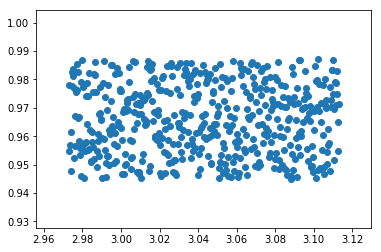

In [22]:
plt.scatter(lhc[:,2], lhc[:,3])

Call this code on our Pks. 

In [ ]:
pk = np.zeros((lhc.shape[0], k_size))

for idx, point in enumerate(lhc):
    #point_output_dirname = os.path.join(output_dir, 'point_%03d'%idx)
    #if not os.path.isdir(point_output_dirname):
    #    os.mkdir(point_output_dirname)
    
    params = OrderedDict(izip(ordered_params.keys(), point))
    print params
    pk[idx] = compute_pk(params)#, point_output_dirname)
    #write_clpt_params(params, point_output_dirname)
    #command = make_kils_command('albert_%03d'%idx, 1, point_output_dirname)
    #call(command, shell = False)

From this generate the training data. 

In [ ]:
def get_data(lhc, ks, pk):
    # convert the lhc and ks' into x and pk into y
    _x = lhc
    r = ks
    x = np.zeros((_x.shape[0]*r.shape[0], _x.shape[1]+1))
    y = np.zeros((x.shape[0], ))

    for idx, row in enumerate(_x):
        x[idx*r.shape[0]:(idx+1)*r.shape[0], :-1] = row
        x[idx*r.shape[0]:(idx+1)*r.shape[0], -1] = r
        
        key = 'point_%03d'%idx
        grp = f[key]

        y[idx*r.shape[0]:(idx+1)*r.shape[0]] = pk[idx]
    
    return x, y

In [ ]:
x, y = get_data(lhc, ks, pk)#, 'xi_l')

In [ ]:
import george
from george.kernels import *

Get out an emulator. 

In [ ]:
emulator_ndim = x.shape[1]
metric = np.ones((emulator_ndim+1,))
a = metric[0]
kernel = a * ExpSquaredKernel(metric[1:], ndim=emulator_ndim)+\
            a*Matern32Kernel(metric[1:], ndim=emulator_ndim)+a

emulator = george.GP(kernel)

emulator.compute(x[:-8000]) 

In [ ]:
y_pred = emulator.predict(y[:-8000], x[-8000:, :])[0]

In [ ]:
np.mean(np.abs(np.abs(y_pred - y[-8000:])/y[-8000:]) )